In [5]:
import numpy as np
import pandas as pd
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
import pyximport
pyximport.install(language_level=3)
import life

In [51]:
a = np.array([[1, 2],[3, 4]])

In [53]:
a.reshape(1, -1, order='F')

array([[1, 3, 2, 4]])

In [120]:
def create_model():
    nn = Sequential()
    nn.add(Conv2D(400, 3, padding='same', activation='relu', input_shape=(20, 20, 1)))
    nn.add(Conv2D(64, 3, padding='same', activation='relu'))
    nn.add(Conv2D(64, 3, padding='same', activation='relu'))
    nn.add(Conv2D(1, 3, padding='same', activation='sigmoid'))
#     nn.add(MaxPool2D())
#     nn.add(Conv2D(400, 3, activation='relu'))
#     nn.add(Conv2D(32, 3, activation='relu'))
#     nn.add(MaxPool2D())
#     nn.add(Conv2D(32, 3, activation='relu'))
#     nn.add(Conv2D(64, 3, activation='relu'))
#     nn.add(Dense(400, activation='relu'))
#     nn.add(Dense(400, activation='relu'))
#     nn.add(Dense(400, activation='sigmoid'))
    nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mae'])
    return nn

In [121]:
es = EarlyStopping(monitor='loss', patience=6, min_delta=0.01)
check = ModelCheckpoint('weights.{epoch:02d}-{acc:.2f}.hdf5', monitor='acc', save_best_only=True)

In [122]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 20, 20, 400)       4000      
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 20, 20, 64)        230464    
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 20, 20, 64)        36928     
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 20, 20, 1)         577       
Total params: 271,969
Trainable params: 271,969
Non-trainable params: 0
_________________________________________________________________


In [123]:
NROW, NCOL = 20, 20

def generate_samples(delta=1, n=32):
    """
    Generate batch of samples
    
    @return: (end_frames, start_frames)
    """
    batch = np.split(np.random.binomial(1, 0.5, (NROW * n, NCOL)).astype('uint8'), n)
    Yy = [life.make_move(state, 5) for state in batch]
    Xx = [life.make_move(state, 1) for state in Yy]
    Y = np.array([y.ravel() for y in Yy])
    X = np.array([x.ravel() for x in Xx])
    return X, Y
    

def data_generator(delta=1, batch_size=32, ravel=True):
    """
    Can be used along with .fit_generator to generate training samples on the fly
    """
    while True:
        batch = np.split(np.random.binomial(1, 0.5, (NROW * batch_size, NCOL)).astype('uint8'), batch_size)
        Yy = [life.make_move(state, 5) for state in batch]
        Xx = [life.make_move(state, delta) for state in Yy]

        if ravel:
            Y = np.array([y.ravel() for y in Yy])
            X = np.array([x.ravel() for x in Xx])
            yield X, Y
        else:
            yield np.array(Xx)[:,:, :, np.newaxis], np.array(Yy)[:, :, :, np.newaxis]

In [124]:
model.fit_generator(data_generator(ravel=False), steps_per_epoch=500, epochs=20, verbose=1, callbacks=[es, check])

Epoch 1/20
500/500 [==============================] - 98s 196ms/step - loss: 0.3446 - acc: 0.8479 - mean_absolute_error: 0.2184
Epoch 2/20
500/500 [==============================] - 96s 191ms/step - loss: 0.3085 - acc: 0.8666 - mean_absolute_error: 0.1911
Epoch 3/20
500/500 [==============================] - 94s 187ms/step - loss: 0.3026 - acc: 0.8696 - mean_absolute_error: 0.1867
Epoch 4/20
500/500 [==============================] - 92s 183ms/step - loss: 0.2986 - acc: 0.8715 - mean_absolute_error: 0.1839
Epoch 5/20
500/500 [==============================] - 98s 197ms/step - loss: 0.2967 - acc: 0.8724 - mean_absolute_error: 0.1826
Epoch 6/20
500/500 [==============================] - 96s 192ms/step - loss: 0.2942 - acc: 0.8738 - mean_absolute_error: 0.1807
Epoch 7/20
500/500 [==============================] - 101s 201ms/step - loss: 0.2931 - acc: 0.8743 - mean_absolute_error: 0.1799
Epoch 8/20
500/500 [==============================] - 105s 210ms/step - loss: 0.2911 - acc: 0.8751 - me

In [90]:
train_df = pd.read_csv('resources/train.csv', index_col=0)

In [125]:
train_pred = model.predict(train_df.iloc[:, 401:].values.reshape(-1, 20, 20, 1)).round(0).astype('uint8')

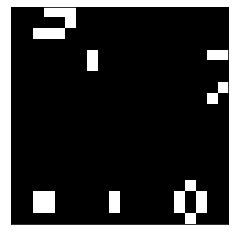

In [118]:
from viz import show_field
show_field(train_df.iloc[1, 1:401].values)

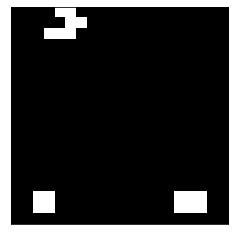

In [119]:
show_field(train_pred[1])

In [126]:
v = (train_pred == train_df.iloc[:, 1:401].values.reshape(-1, 20, 20, 1))

In [127]:
v.sum() / (v.shape[0] * v.shape[1] * v.shape[2])

0.865594

In [41]:
v = (np.zeros_like(pred) == single_delta.iloc[:, 1:401]).values
v.sum() / (v.shape[0] * v.shape[1])

0.8549888663967611

In [23]:
test_df = pd.read_csv('resources/test.csv', index_col=0)

In [24]:
submit_df = pd.DataFrame(model.predict(test_df.iloc[:, 1:]).round(0).astype('uint8'), 
                         index=test_df.index, columns=['start.' + str(_) for _ in range(1, 401)])

In [25]:
submit_df.to_csv('nn_submit_v2.csv')